# PCA

In [ ]:
import notebook.services.api.handlers
import pandas as pd

from models.helpers_talent import *
from models.VAE import *

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# clustering namespaces
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

from statsmodels.multivariate.pca import PCA

import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from sklearn.manifold import TSNE
plt.rcParams['figure.figsize'] = (15, 12)
import warnings
warnings.filterwarnings('ignore')
save_dir = 'saved_models/tfp'

In [ ]:
# <editor-fold desc="DATA">
# DATA
group = 1           # age class 'AK'
test_size = 0.2     # train-test split

# normal with subjective meassures = TRUE/FALSE
# dat, X_0, y_0, _, _, _, _ = load_data(group=group, test_size=test_size, sub=True) # subjectives = True
dat, _, _, X, X_test, y, y_test = load_data(group=group, test_size=test_size, sub=False)

X_0_names = list(X.columns)
X_names = ['birthday', 'height', 'weight', 'SL20', 'GW','DR','BK','BJ','SKSC_TAK','SKSC_TEC','SKSC_KON','SKSC_PSY']
# ___ SCALING
df = X
scaler = StandardScaler().fit(X)
df = scaler.transform(df)

data = dat.copy()
scaler_data = StandardScaler().fit(data.iloc[:,2:14])
data.iloc[:,2:14] = scaler_data.transform(data.iloc[:,2:14])

data = pd.DataFrame(data, columns=dat.columns)
# </editor-fold>

## Number of clusters

### Elbow method (within cluster sum of square)

In [ ]:

def n_clusters(data, max_range, method='elbow'):
    temp = []
    if method=='elbow':
        for k in range(1, max_range+1):
            min_range=1
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(data)
            temp.append(kmeans.inertia_)  # interia_ = total WSS (within-cluster sum of square)
    else:
        for k in range(2, max_range+1):
            min_range=2
            kmeans = KMeans(n_clusters=k)
            labels = kmeans.fit_predict(df)
            temp.append(silhouette_score(df, labels))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(min_range, max_range+1), temp)
    plt.grid(True)
    plt.title(method)        # vllt 2?

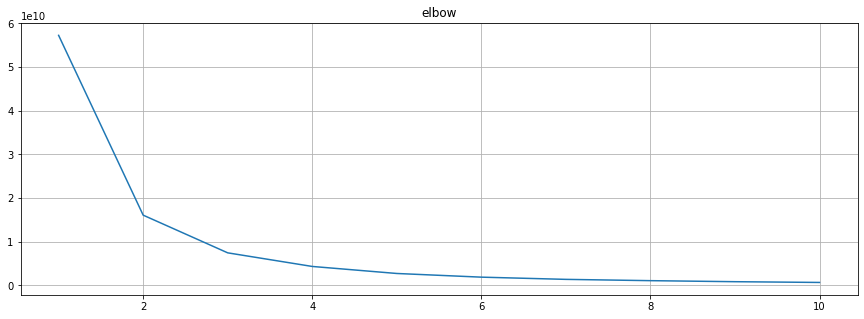

In [ ]:
n_clusters(data, 10, method='elbow')

For n_clusters = 2 The average silhouette_score is : 0.6114516427213558


TypeError: '(slice(None, None, None), 0)' is an invalid key

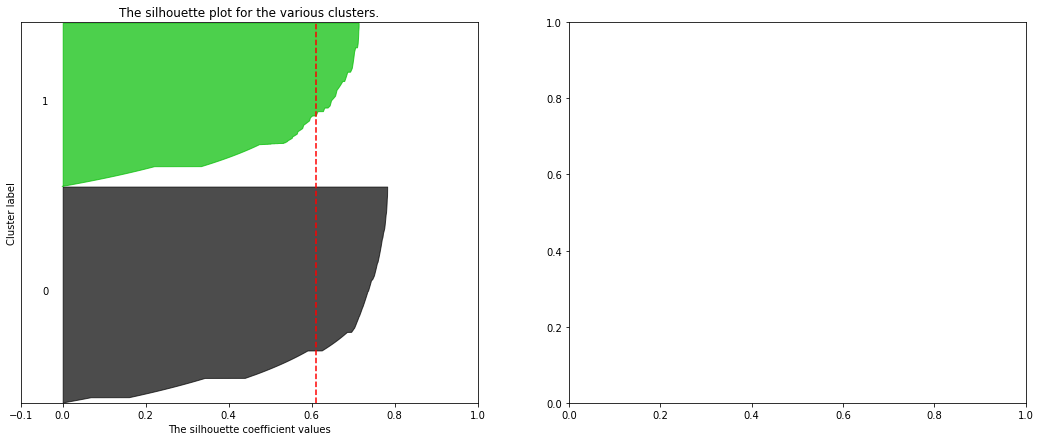

In [ ]:
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

data_sil = data
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_sil) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_sil)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_sil, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_sil, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_sil[:, 0], data_sil[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# Pure Clustering

In [ ]:
dat_kmeans = dat.copy()
kmeans = KMeans(n_clusters=2)
kmeans_model = kmeans.fit(dat_kmeans.iloc[:,:-1])
kmeans_labels = kmeans_model.predict(dat_kmeans.iloc[:,:-1])
dat_kmeans['km_label'] = kmeans_labels

In [ ]:
kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Describe

In [ ]:
dat_0 = dat_kmeans[dat_kmeans['km_label']==0]
dat_1 = dat_kmeans[dat_kmeans['km_label']==1]

In [ ]:
print('Frequence in cluster 0:,', round(dat_0.describe().iloc[1,16],4), ', frequence in cluster 1: ', round(dat_1.describe().iloc[1,16],4))

Frequence in cluster 0:, 0.0571 , frequence in cluster 1:  0.1282


In [ ]:
kmeans_describe = pd.concat([dat_0.describe().iloc[1:3,2:14].T,dat_1.describe().iloc[1:3,2:14].T], axis=1)
kmeans_describe

,mean,std,mean,std
Geburtstag_Taggenau,176.474106,103.061129,137.328530,96.579114
Grösse,145.983449,4.165693,156.776297,4.201162
Gewicht,36.215323,4.083171,42.615313,5.014710
SL20,3.647301,0.158198,3.618469,0.159608
GW,8.323564,0.392059,8.417021,0.400310
DR,10.991660,0.744120,11.088581,0.753413
BK,10.267104,1.325355,10.160022,1.348581
BJ,2.509076,3.010005,2.803314,3.369102
SKSC_TAK,1.491000,0.603224,1.502676,0.588653
SKSC_TEC,1.313490,0.564271,1.428674,0.561169


In [ ]:
round(kmeans_describe,2).to_latex(escape=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &    mean &     std &    mean &    std \\\\\n\\midrule\nGeburtstag_Taggenau &  176.47 &  103.06 &  137.33 &  96.58 \\\\\nGrösse              &  145.98 &    4.17 &  156.78 &   4.20 \\\\\nGewicht             &   36.22 &    4.08 &   42.62 &   5.01 \\\\\nSL20                &    3.65 &    0.16 &    3.62 &   0.16 \\\\\nGW                  &    8.32 &    0.39 &    8.42 &   0.40 \\\\\nDR                  &   10.99 &    0.74 &   11.09 &   0.75 \\\\\nBK                  &   10.27 &    1.33 &   10.16 &   1.35 \\\\\nBJ                  &    2.51 &    3.01 &    2.80 &   3.37 \\\\\nSKSC_TAK            &    1.49 &    0.60 &    1.50 &   0.59 \\\\\nSKSC_TEC            &    1.31 &    0.56 &    1.43 &   0.56 \\\\\nSKSC_KON            &    1.74 &    0.75 &    1.72 &   0.75 \\\\\nSKSC_PSY            &    1.74 &    0.67 &    1.74 &   0.67 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
 print(dat_0.shape, dat_1.shape)

(3746, 18) (2776, 18)


### t-tests

In [ ]:
from scipy.stats import ttest_ind
stats = []
ps = []
for i in range(dat_0.iloc[:,2:14].shape[1]):
    stat, p = ttest_ind(dat_0.iloc[:, 2+i],dat_1.iloc[:, 2+i])
    stats.append(stat)
    ps.append(p)
    print(kmeans_describe.index[i], stats[i], ps[i])

Geburtstag_Taggenau 15.575910349785666 9.778014199561928e-54
Grösse -103.08066718325989 0.0
Gewicht -56.74862073180536 0.0
SL20 7.249856505624552 4.654204075552363e-13
GW -9.43340979504309 5.399702067146448e-21
DR -5.173258947121469 2.3691123106570592e-07
BK 3.202167877803679 0.00137052691876945
BJ -3.708864458296179 0.00020992077047339385
SKSC_TAK -0.7808684380136196 0.4349082267612685
SKSC_TEC -8.17005396924272 3.6710891148381917e-16
SKSC_KON 1.1064378683491396 0.2685778635711242
SKSC_PSY -0.35306090107008703 0.7240541977344683


# PCA

In [ ]:
from sklearn.decomposition import PCA
#pca_scree = PCA(n_components = 0.75, svd_solver='full')
pca_scree = PCA(svd_solver='full')
pca_scree.fit(data.iloc[:,2:14])
reduced = pca_scree.transform(data.iloc[:,2:14])

,Geburtstag_Taggenau,Grösse,Gewicht,SL20,GW,DR,BK,BJ,SKSC_TAK,SKSC_TEC,SKSC_KON,SKSC_PSY
0,1.596938,-4.510768,-1.987778,-2.101627,-0.887303,-0.244044,0.156028,-0.200057,-0.830767,-1.819179,-2.308963,-2.105117
1,-0.115594,-3.478126,-2.805465,1.599424,-1.766213,-2.125278,0.477852,-0.830837,1.322850,1.126813,0.357773,1.881547
2,1.254432,-3.330606,-2.405707,1.285775,-0.385069,-0.110623,0.492821,-0.830837,-1.070058,-1.819179,-0.975595,-1.606784
3,-0.438529,-3.183086,-2.351194,-0.784304,-0.786856,-0.951175,0.530242,-0.515447,0.604978,-1.229981,0.357773,0.386548
4,0.608562,-3.183086,-2.278511,1.599424,0.644510,0.089508,0.694896,0.115334,-1.548639,-1.229981,-0.975595,-1.108451
...,...,...,...,...,...,...,...,...,...,...,...,...
6517,-0.389599,3.602847,2.554929,-1.599789,0.744957,0.236271,-0.382840,3.900017,0.365687,-0.051584,0.357773,0.884881
6518,-1.270331,3.750367,3.826886,-2.728923,1.272303,0.970085,-0.061016,-0.200057,0.126396,-0.051584,0.357773,0.386548
6519,1.185931,3.750367,0.556138,-0.658844,0.870516,0.916717,-0.352903,-0.830837,0.126396,0.537614,0.357773,0.386548
6520,-1.534550,3.897887,3.463470,-1.599789,-0.033505,-0.470860,-0.839381,1.061504,2.280014,0.537614,0.357773,1.383214


In [ ]:
#pca_scree.explained_variance_ratio_
pca_scree.explained_variance_

array([3.42208143, 1.94702864, 1.53418153, 1.12879006, 0.87929339,
       0.7361248 , 0.71515128, 0.45016589, 0.42639909, 0.33058544,
       0.24990049, 0.18213816])

Text(0.5, 1.0, 'Scree Plot')

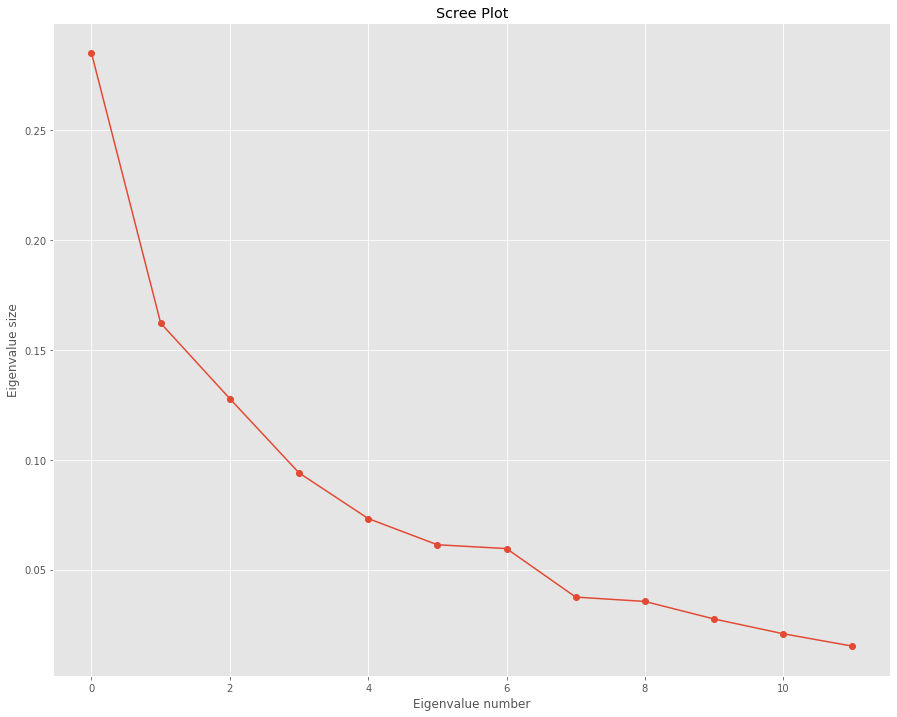

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(pca_scree.explained_variance_ratio_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [ ]:
pca = PCA(n_components = 4, svd_solver='full',)
pca.fit(data.iloc[:,2:14])
reduced = pca.transform(data.iloc[:,2:14])
loadings = pd.DataFrame(pca.components_.T)

[Text(0.5, 1, 'PCA loadings (a)')]

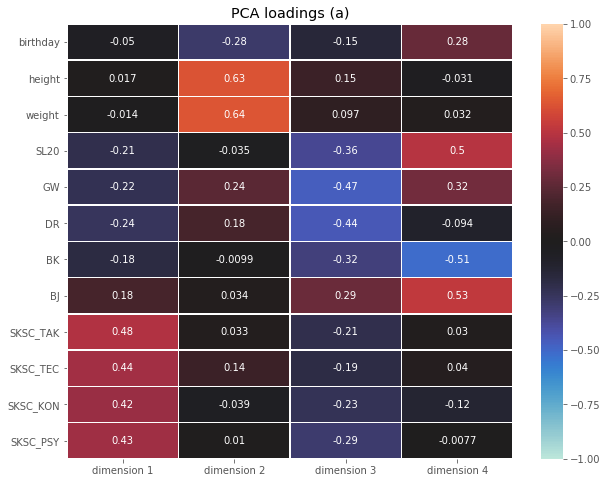

In [ ]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=loadings, annot=True, linewidths=0.5, vmin=-1, vmax=1, center=0,xticklabels=["dimension 1", "dimension 2","dimension 3","dimension 4"], yticklabels=X_names).set(title='PCA loadings (a)')

### Explained variance

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.6692375110624255

# EFA

In [ ]:
from factor_analyzer import FactorAnalyzer

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
#pca_scree = PCA(n_components = 0.75, svd_solver='full')
pca_scree = PCA(svd_solver='full')
pca_scree.fit(data.iloc[:,2:14])
reduced = pca_scree.transform(data.iloc[:,2:14])

In [ ]:
#pca_scree.explained_variance_ratio_
pca_scree.explained_variance_

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(pca_scree.explained_variance_ratio_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [ ]:
pca = PCA(n_components = 4, svd_solver='full',)
pca.fit(data.iloc[:,2:14])
reduced = pca.transform(data.iloc[:,2:14])
loadings = pd.DataFrame(pca.components_.T)

In [ ]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=loadings, annot=True, linewidths=0.5, vmin=-1, vmax=1, center=0,xticklabels=["dimension 1", "dimension 2","dimension 3","dimension 4"], yticklabels=X_names).set(title='PCA loadings (a)')

In [ ]:
np.sum(pca.explained_variance_ratio_)